# Credit Card Fraud Detection

# Introduction

The dataset contains 284,807 transactions made by credit cards during two days of September 2013 by european cardholders.<br>
Credit card companies need to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

**Goal**<br>
Build a predictive model to identify fraudulent credit card transactions (supervised binary classification problem).

**Data**<br>
According to the Kaggle 'Overview' tab:
- Features V1, V2, ... V28 are the principal components obtained by PCA
- Feature 'Time' contains the seconds elapsed between a transaction and the first transaction in the dataset
- Feature 'Amount' is the transaction Amount
- Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

**Metric**<br>
The dataset is highly unbalanced:
- 492 fraudulent transactions vs. 284,315 genuines
- So the positive class (Frauds) account for 0.172% of all transactions.

1. First, we want to catch frauds. It means: minimizing the False Negative rate
> Recall
2. Then we want to minimize the False Positive rate
> Precision

    **The Area under the Precision-Recall curve is the compromise metrics in this Precision-Recall trade-off.**<br>
   
<br>

**Outline**<br>

1. [Load Dataset](#load dataset)<br>

2. [Summarize Dataset](#summarize dataset)<br>
2.1. [Descriptive Statistics](#descriptive statistics)<br>
2.2. [Data Visualization](#data visualization)<br>
2.2.1. [When does frauds happen?](#time)<br>
2.2.2. [What is the amount of a fraud transaction?](#amount)<br>
2.2.3. [Correlations](#correlations)<br>

3. [Prepare Dataset](#prepare dataset)<br>
3.1. [Feature selection](#feature selection)<br>
3.2. [Data Transform](#data transforms)<br>
3.3. [Subsampling](#subsampling)<br>

4. [50/50 Dataset](#50/50 dataset)<br>
4.1. [Split-out validation Dataset](#50/50 split-out)<br>
4.2. [Set Metrics](#50/50 metrics)<br>
4.3. [Spot Check Algorithms](#50/50 spot check)<br>
4.3.1. [Train and Test Sets](#50/50 train test)<br>
4.3.2. [K-Fold cross validation](#50/50 kfold)<br>
4.4. [Classifiers Tuning](#tuning)<br>
4.4.1. [SVM Tuning](#svm tuning)<br>
4.4.2. [XGBoost Tuning](#xgb tuning)<br>
4.5 [Conclusion](#50/50 conclusion)<br>

# 1. Load dataset
<a id="load dataset"></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

seed = 7

%matplotlib inline

dataset = pd.read_csv('../input/creditcard.csv')

print('This dataset contains ',dataset.shape[0],'rows')
print('This dataset contains ',dataset.shape[1],'columns')

This dataset contains  284807 rows
This dataset contains  31 columns


In [2]:
dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [4]:
# Check if NA values are present
dataset.isnull().sum().sum()

0

In [5]:
# Change the type of the Class column
dataset.Class = dataset.Class.astype('bool')

# Get the count of each Class
dataset.groupby('Class').size()

Class
False    284315
True        492
dtype: int64

> There is no 'NA' values.

> The dataset is unbalanced.

# 2. Summarize Data
<a id="summarize dataset"></a>

## 2.1. Descriptive Statistics
<a id="descriptive statistics"></a>

In [6]:
dataset.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000


## 2.2. Data Visualization
<a id="data visualization"></a>

In [7]:
import seaborn as sns

frauds = dataset[dataset.Class==True]
genuines = dataset[dataset.Class==False]

### 2.2.1. When does frauds happen?
<a id="time"></a>

>Hypothesis: Frauds happen at night.

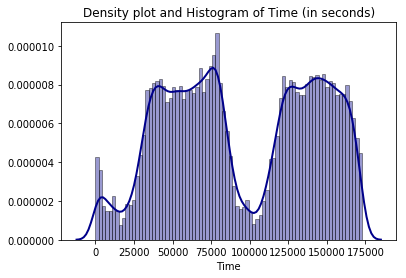

In [8]:
# 'Time' visualization
sns.distplot(dataset.Time,
             bins=80, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.title('Density plot and Histogram of Time (in seconds)')
plt.show()

> A day is 86,400 seconds so we can recongnize the 2 days of transactions. Each top of slope correspond to a day and each valley correspond to a night.

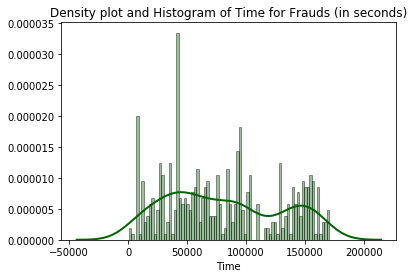

In [9]:
# 'Time' visualization for frauds
sns.distplot(frauds.Time,
             bins=80, color = 'darkgreen', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.title('Density plot and Histogram of Time for Frauds (in seconds)')
plt.show()

>Density is more flat for frauds. So the proportion of frauds may be higher at night.

### 2.2.2. What is the amount of a fraud transaction?
<a id="amount"></a>

>Hypothesis: the higher an amount is, the more likely the transaction is fraudulent.

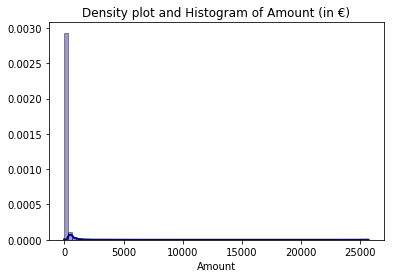

In [10]:
# 'Amount' visualization
# According to the Introduction, we assume the currency is Euro
sns.distplot(dataset.Amount, 
             bins=80, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.title('Density plot and Histogram of Amount (in €)')
plt.show()

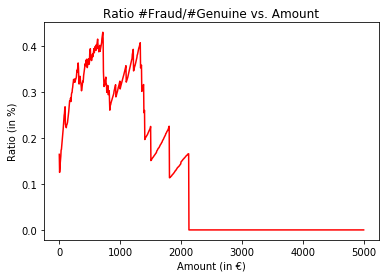

In [11]:
# Ratio of Frauds vs. Amount
amounts = np.linspace(0,5000,1001)
ratios = np.array([])

for amount in amounts:
    
    nbGenuine = len(genuines[genuines.Amount > amount])
    nbFrauds = len(frauds[frauds.Amount > amount])
    ratio = 100*nbFrauds/nbGenuine
    
    ratios = np.append(ratios,ratio)

plt.plot(amounts,ratios,'r-')
plt.title('Ratio #Fraud/#Genuine vs. Amount')
plt.xlabel('Amount (in €)')
plt.ylabel('Ratio (in %)')
plt.show()

>Contrary to what we could believe, a large amount in a transaction does not involve that it is a fraud.

### 2.2.3. Correlations
<a id="correlations"></a>

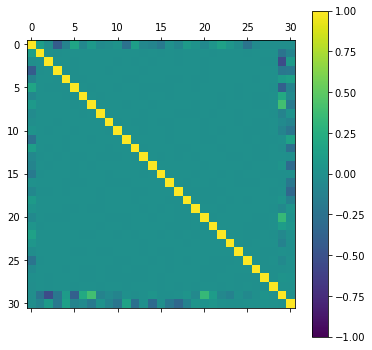

In [12]:
from pandas.plotting import scatter_matrix

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
cax = ax.matshow(dataset.corr(), vmin=-1, vmax=1, interpolation='none')
fig.colorbar(cax)
plt.show()

>'V' predictors are not correlated to each other. Indeed, as Principal Components, there are orthogonal to each other.

>The 'blurred' border is due to column 'Time', 'Amount' and 'Class': there are no significant correlation between the variables.

# 3. Prepare Dataset
<a id="prepare dataset"></a>

## 3.1. Feature Selection
<a id="feature selection"></a>

>'V1' to 'V28' have already been preprocessed. We will use them as predictors. We have to decide if we use 'Time' and 'Amount' as predictors:
- As it is, 'Time' does not seem very relevant.
- As it is, 'Amount' should already brings information.

## 3.2. Data Transforms
<a id="data transforms"></a>

>We will not apply any transformation to variables 'V1', 'V2', ... , 'V28'.
>'Time' and 'Amount' could be transformed:
- 'Time' could be use to set a new boolean variable called 'Day' (_True_ for Day, _False_ for Night, cf.[previousely](#time)). So regarding the 'Time' variable, we could either:
    1. Not use it
    2. Or replace it by 'Day' 
- 'Amount' could be use:
    1. As it is
    2. Normalized
    3. Standardized
    
## 3.3. Subsampling
<a id="subsampling"></a>

>To continue our analysis of the dataset, we could:
1. Use the whole dataset as it is: so no sampling
2. Create a new dataset composed of the 492 frauds and of 492 random genuine transactions (50/50 sampling). If so, we would have to ensure that the 492 random genuine transactions are representative of the genuine transactions...
3. A way to manage this  would be to resample 492 genuine transactions randomly N times and to compare results.

>So different configurations for our dataset are possible regarding 'Time', 'Amount' and subsampling:

>| 'Time'               | 'Amount'        |      Subsampling |
>| :------------        | :-------------: | -------------:   |
>| Not use it           | As it is        |               No |
>| Replace it by 'Day'  | Normalized      |            50/50 |
>|                      | Standardized    |    N times 50/50 |

>If you are curious about which configuration brings the best results, go for it!

>Next in this notebook, we will explore one of those configuration.

# 4. 50/50 Dataset
<a id="50/50 dataset"></a>

>As a first step in this analysis, we will use the following highlighted configuration for our dataset:

>| 'Time'               | 'Amount'        |      Subsampling |
>| :------------        | :-------------: | -------------:   |
>| _**Not use it**_     | _**As it is**_  |             No   |
>| Replace it by 'Day'  | Normalized      |      _**50/50**_ |
>|                      | Standardized    |  N times 50/50   |

>Let's create the new dataset.

In [13]:
# We randomly select 492 genuine transactions
genuines_sub = genuines.sample(492, random_state=seed)

# dataset_sub is the dataset composed of 492 frauds and of 492 genuine transactions
dataset_sub = frauds.append(genuines_sub, ignore_index=True)

# We drop the 'Time' column
dataset_sub = dataset_sub.drop('Time',axis=1)

print('This sub dataset contains ',dataset_sub.shape[0],'rows')
print('This sub dataset contains ',dataset_sub.shape[1],'columns')

This sub dataset contains  984 rows
This sub dataset contains  30 columns


In [14]:
dataset_sub.groupby('Class').size()

Class
False    492
True     492
dtype: int64

## 4.1. Split-out validation Dataset
<a id="50/50 split-out"></a>

In [15]:
from sklearn.model_selection import train_test_split

# Predictors
X = dataset_sub.drop('Class',axis=1)

# Response
y = dataset_sub.Class

# Split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state = seed)

# Proportion of fraud in train set and test set
print('Proportion of fraud in train:',y_train[y_train == True].shape[0]/X_train.shape[0])
print('Proportion of fraud in test:',y_test[y_test == True].shape[0]/X_test.shape[0])

Proportion of fraud in train: 0.5108005082592122
Proportion of fraud in test: 0.45685279187817257


>Proportion should be 50/50

## 4.2. Set metrics
<a id="50/50 metrics"></a>

>As evoked in the Introduction, we will use the following metrics:
- Precision
- Recall
- Area under the Precision-Recall Curve

>Confusion matrix will also be used

>**We have to take into account those metrics to find the best compromise in the Recall-Precision trade-off. Here are some extrem cases we want to avoid:**
- Recall = 1, Precision = 0: the Naive classifier that classify all transactions as Frauds
- Recall = 0, Precision = 1: the Naive classifier that classify all transactions as Genuines
- Recall = 0.5, Precision = 0.5: the Random classifier that classify randomly all transactions

>**The Area Under the Precision-Recall Curve (AUPCR) will be our standard metric ([average_precision](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html)).**

In [16]:
from sklearn.metrics import recall_score, precision_recall_curve, average_precision_score, confusion_matrix, precision_score

scoring = 'average_precision'

## 4.3. Spot Check Algorithms
<a id="50/50 spot check"></a>

>First, the following classifier would be tested:
- Logistic Regression
- Linear Discriminant Analysis
- Quadratic Discriminant Analysis
- Support Vector Machine

>Then the following Ensemble methods would be tested:
- Random Forest
- Ada Boost
- Stochastic Gradient Boosting
- XGBoost

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import xgboost

models = []
models.append(('LR',LogisticRegression(random_state=seed)))
models.append(('LDA',LinearDiscriminantAnalysis()))
models.append(('QDA',QuadraticDiscriminantAnalysis()))
models.append(('SVM',SVC(random_state=seed,gamma='scale')))

ensembles = []
ensembles.append(('RF', RandomForestClassifier(random_state=seed,n_estimators=100)))
ensembles.append(('ADA', AdaBoostClassifier(random_state=seed)))
ensembles.append(('GBM', GradientBoostingClassifier(random_state=seed)))
ensembles.append(('XGB', XGBClassifier(random_state=seed)))

### 4.3.1. Train and Test Sets
<a id="50/50 train test"></a>

>First, we evaluate the performance of our classifier with a direct train-test stragtegy.

In [18]:
# Models evaluation function
def get_score_models(model,X_train,X_test,y_train,y_test):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    
    # All our models implement the 'decision_function' method
    # It is not the case of all our ensembles
    y_score = model.decision_function(X_test)
    
    compare(y_test,y_pred,y_score)
    
# Ensembles evaluation function
def get_score_ensembles(ensemble,X_train,X_test,y_train,y_test):
    ensemble.fit(X_train,y_train)
    y_pred = ensemble.predict(X_test)
    
    # All our ensembles implement the 'predict_proba' method
    # It is not the case of all our models
    y_score = ensemble.predict_proba(X_test)[:,1]
    
    compare(y_test,y_pred,y_score)

# Print metrics and graph function
def compare(y_test,y_pred,y_score):
    print('Confusion matrix:')
    print(confusion_matrix(y_test,y_pred))
    
    print('Recall:',recall_score(y_test,y_pred))
    print('Precision:',precision_score(y_test,y_pred))
    print('Area under the curve:',average_precision_score(y_test,y_score))
    
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    plt.step(recall, precision, alpha=0.4, color='b', where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', step='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0, 1.05])
    plt.xlim([0, 1])
    plt.title('Precision-Recall curve')
    plt.show()

---------- LR ----------
Confusion matrix:
[[102   5]
 [  7  83]]
Recall: 0.9222222222222223
Precision: 0.9431818181818182
Area under the curve: 0.9671510692760011


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


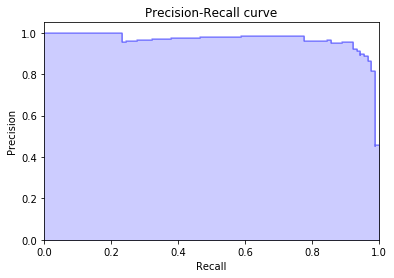

---------- LDA ----------
Confusion matrix:
[[103   4]
 [ 13  77]]
Recall: 0.8555555555555555
Precision: 0.9506172839506173
Area under the curve: 0.9259319943143265


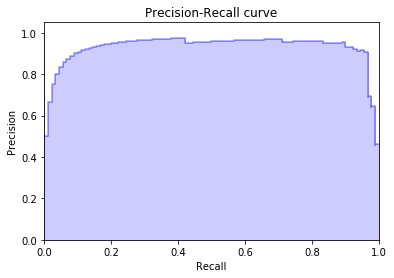

---------- QDA ----------
Confusion matrix:
[[100   7]
 [  5  85]]
Recall: 0.9444444444444444
Precision: 0.9239130434782609
Area under the curve: 0.9803799672269176


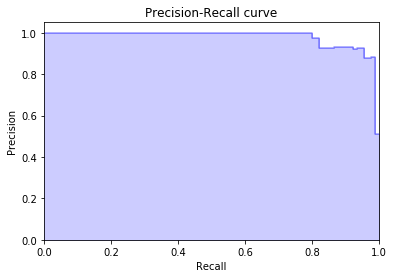

---------- SVM ----------
Confusion matrix:
[[101   6]
 [ 25  65]]
Recall: 0.7222222222222222
Precision: 0.9154929577464789
Area under the curve: 0.9435906459966247


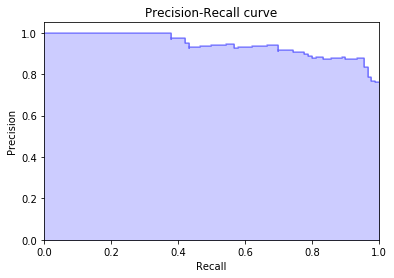

In [19]:
# Evaluation of each model
for name,model in models:
    print('----------',name,'----------')
    get_score_models(model,X_train,X_test,y_train,y_test)

---------- RF ----------
Confusion matrix:
[[102   5]
 [  8  82]]
Recall: 0.9111111111111111
Precision: 0.9425287356321839
Area under the curve: 0.984161871314936


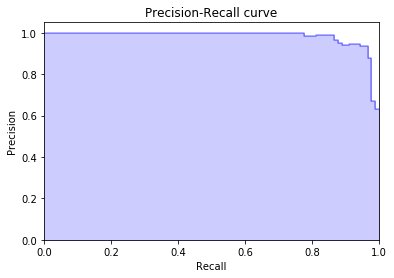

---------- ADA ----------
Confusion matrix:
[[99  8]
 [ 4 86]]
Recall: 0.9555555555555556
Precision: 0.9148936170212766
Area under the curve: 0.9812242159890032


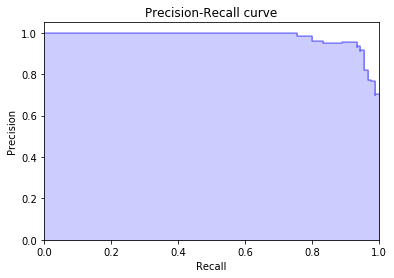

---------- GBM ----------
Confusion matrix:
[[103   4]
 [  7  83]]
Recall: 0.9222222222222223
Precision: 0.9540229885057471
Area under the curve: 0.9449186668704573


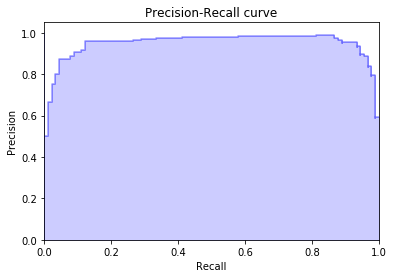

---------- XGB ----------
Confusion matrix:
[[102   5]
 [  5  85]]
Recall: 0.9444444444444444
Precision: 0.9444444444444444
Area under the curve: 0.9841756307441143


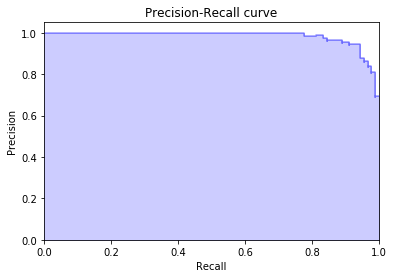

In [20]:
# Evaluation of each ensemble method
for name,ensemble in ensembles:
    print('----------',name,'----------')
    get_score_ensembles(ensemble,X_train,X_test,y_train,y_test)

**Train-Test Split conclusion**

>Classifiers results:

>| Model          | Recall (in %)  | _AUPRC (in %)_ | _Precision (in %)_ |
>| :------------  | :------------: | :------------: |   ---------------: |
>| LR             | 92.2           |           96.7 |             _94.3_ |
>| LDA            | 85.6           |           92.6 |             _95.1_ |
>| QDA            | 94.4           |           98.0 |             _92.4_ |
>| SVM            | **97.8**       |           94.7 |             _84.6_ |
>| **RF**         | 94.4           |       **98.4** |             _95.5_ |
>| ADA            | 95.6           |           98.1 |             _91.5_ |
>| GBM            | 92.2           |           94.5 |             _95.4_ |
>| **XGB**        | 94.4           |       **98.4** |             _94.4_ |

>- Focused on Recall, the SVM classifier get the best score _(on this particular Train-Test split)_. But in the same time, the SVM classifier has one of the poorest precision rate.

>- Regarding the Area under the Precision-Recall curve, **Random Forest** and **XGBoost** get the best score.

### 4.3.2. K-Fold cross validation
<a id="50/50 kfold"></a>

>Now, we evaluate the performance of our classifiers with a 10-Fold cross validation.

In [22]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

num_folds = 10
kfold = KFold(n_splits=num_folds,random_state=seed)

names = []
results_recall = []
results_aupcr = []
models_score = {}
ensembles_score = {}

# Function cross validating and printing Recall and AUPRC results
def cross_validation(name,classifier,classifiers_score,results_recall,results_aupcr):
    cv_results_recall = cross_val_score(model,X_train,y_train,cv=kfold,scoring='recall')
    cv_results_auprc = cross_val_score(model,X_train,y_train,cv=kfold,scoring=scoring)

    models_score[name] = [cv_results_recall.mean()]
    models_score[name].append(cv_results_recall.std())
    models_score[name].append(cv_results_auprc.mean())
    models_score[name].append(cv_results_auprc.std())
    
    results_recall.append(cv_results_recall)
    results_aupcr.append(cv_results_auprc)
    names.append(name)

    print('----------',name,'----------')
    print('Recall:',models_score[name][0],'(',models_score[name][1],')')
    print('AUPRC:',models_score[name][2],'(',models_score[name][3],')\n')

In [23]:
# 10-Fold cross validation on our models
for name,model in models:
    cross_validation(name,model,models_score,results_recall,results_aupcr)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

---------- LR ----------
Recall: 0.9132052706825204 ( 0.05739953397995212 )
AUPRC: 0.9832935383959646 ( 0.011372124102402096 )

---------- LDA ----------
Recall: 0.8533617365518277 ( 0.051487574015210515 )
AUPRC: 0.9732472764360562 ( 0.017218352439047024 )

---------- QDA ----------
Recall: 0.898284401691884 ( 0.05339055092333472 )
AUPRC: 0.9790382484421839 ( 0.012129553708604787 )

---------- SVM ----------
Recall: 0.6881530013329811 ( 0.08026473209228271 )
AUPRC: 0.934526458522645 ( 0.033416272753997944 )



In [24]:
# 10-Fold cross validation on ensembles
for name,ensemble in ensembles:
    cross_validation(name,ensemble,ensembles_score,results_recall,results_aupcr)

---------- RF ----------
Recall: 0.6881530013329811 ( 0.08026473209228271 )
AUPRC: 0.934526458522645 ( 0.033416272753997944 )

---------- ADA ----------
Recall: 0.6881530013329811 ( 0.08026473209228271 )
AUPRC: 0.934526458522645 ( 0.033416272753997944 )

---------- GBM ----------
Recall: 0.6881530013329811 ( 0.08026473209228271 )
AUPRC: 0.934526458522645 ( 0.033416272753997944 )

---------- XGB ----------
Recall: 0.6881530013329811 ( 0.08026473209228271 )
AUPRC: 0.934526458522645 ( 0.033416272753997944 )



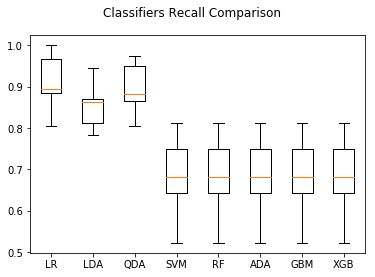

In [25]:
# Compare Classifiers regarding Recall
fig = plt.figure()
fig.suptitle('Classifiers Recall Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results_recall)
ax.set_xticklabels(names)
plt.show()

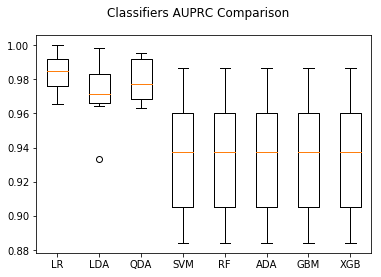

In [26]:
# Compare Classifiers regarding the Precision
fig = plt.figure()
fig.suptitle('Classifiers AUPRC Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results_aupcr)
ax.set_xticklabels(names)
plt.show()

**10-Fold cross validation conclusion**

>Classifiers results:

>| Model          | Mean Recall (in %) | Std Recall (in %) | Mean AUPCR (in %) | Std AUPCR (in %) |
>| :------------  | :-------------:    |   :-------------: | :---------------: | ---------------: |
>| LR             | 91.3               |              5.74 |              98.3 |             1.14 |
>| LDA            | 85.3               |              5.15 |              97.3 |             1.72 |
>| QDA            | 89.8               |              5.34 |              97.9 |             1.21 |
>| **SVM**        | **92.2**           |              3.94 |              96.4 |             2.61 |
>| RF             | 88.7               |              4.34 |              97.1 |             1.60 |
>| ADA            | 91.7               |              5.48 |              98.3 |             1.33 |
>| GBM            | 90.2               |              5.84 |              98.3 |             1.03 |
>| **XGB**        | 91.6               |              5.71 |          **98.5** |             1.03 |

>- Again, focused on recall, the SVM classifier get the best score _(on this particular genuine subsample)_. But in the same time, the SVM classifier has the poorest AUPCR.

>- Regarding Area under the Precision-Recall curve, **XGBoost** get the best score _(Note that the Random Forest get poorer results by cross validation)_.


## 4.4. Classifiers Tuning
<a id="tuning"></a>

>Before switching to a new configuration of our dataset, let's try to get a better AUPCR for the Support Vector Classifier and the XGBoost by tuning their parameter.

### 4.4.1. SVM Tuning
<a id="svm tuning"></a>

>For the SVM Classifier, the following parameters will be explored:
- _C_: the penalty of the error term
- _kernel_: the kernel type used by the algorithm.

In [27]:
from sklearn.model_selection import GridSearchCV

# Function executing the Grid Search and printing the result
def search_param(model,X_train,y_train,param_grid,scoring,kfold):
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid_result = grid.fit(X_train, y_train)
    
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

In [28]:
# /!\ May take some time
# SVC Parameters values that will be tested:
C = [0.001,0.01,0.1,1]
kernel_values = ['rbf', 'sigmoid', 'linear']

param_grid = dict(C=C,kernel=kernel_values)

model = SVC(random_state=seed,gamma='scale')

search_param(model,X_train,y_train,param_grid,scoring,kfold)

Best: 0.986284 using {'C': 0.001, 'kernel': 'linear'}
0.818765 (0.079536) with: {'C': 0.001, 'kernel': 'rbf'}
0.599489 (0.101966) with: {'C': 0.001, 'kernel': 'sigmoid'}
0.986284 (0.010814) with: {'C': 0.001, 'kernel': 'linear'}
0.817252 (0.082313) with: {'C': 0.01, 'kernel': 'rbf'}
0.599326 (0.102056) with: {'C': 0.01, 'kernel': 'sigmoid'}
0.985782 (0.009425) with: {'C': 0.01, 'kernel': 'linear'}
0.825593 (0.081782) with: {'C': 0.1, 'kernel': 'rbf'}
0.568413 (0.106304) with: {'C': 0.1, 'kernel': 'sigmoid'}
0.984452 (0.010668) with: {'C': 0.1, 'kernel': 'linear'}
0.934548 (0.033438) with: {'C': 1, 'kernel': 'rbf'}
0.726788 (0.069897) with: {'C': 1, 'kernel': 'sigmoid'}
0.983090 (0.012213) with: {'C': 1, 'kernel': 'linear'}


In [29]:
# kernel = 'linear'
# C contained in [0.001;0.01]
C = np.linspace(0.001,0.01,10)
param_grid = dict(C=C)

model = SVC(kernel='linear',random_state=seed)

search_param(model,X_train,y_train,param_grid,scoring,kfold)

Best: 0.986300 using {'C': 0.002}
0.986284 (0.010814) with: {'C': 0.001}
0.986300 (0.010327) with: {'C': 0.002}
0.985963 (0.010215) with: {'C': 0.003}
0.986091 (0.009846) with: {'C': 0.004}
0.986078 (0.010076) with: {'C': 0.005}
0.985699 (0.009935) with: {'C': 0.006}
0.986089 (0.009289) with: {'C': 0.007}
0.985903 (0.009347) with: {'C': 0.008}
0.985916 (0.009327) with: {'C': 0.009000000000000001}
0.985782 (0.009425) with: {'C': 0.01}


> With (kernel='linear', C = 0.002), SVM Classifier get 98.6% AUPRC.

In [30]:
# Check the Recall for the tuned SVM
model = SVC(kernel='linear',C=0.002,random_state=seed)
cv_results = cross_val_score(model,X_train,y_train,cv=kfold,scoring='recall')

print('Recall:',cv_results.mean(),'(',cv_results.std(),')')

Recall: 0.8589908606592125 ( 0.047535979445284295 )


> Default SVM Classifier scores (C = 1.0, kernel = 'rbf'):
- AUPCR: 96.4 % (_2.61_ %)
- Recall: **92.2** % (_3.94_ %)

> Tuned SVM Classifier scores (C = 0.002, kernel = 'linear'):
- AUPCR: **98.6** % (_1.03_ %)
- Recall: 85.9 % (_4.75_ %)

### 4.4.2. XGBoost Tuning
<a id="xgb tuning"></a>

>For the XGBoost Classifier, the following parameters will be explored:
- *learning_rate*: the Boosting learning rate (xgb’s 'eta')
- *n_estimators*: the Number of boosted trees to fit
- *max_depth*: the maximum tree depth for base learners.

In [31]:
# /!\ Take some time
# XGBoost Parameters values that will be tested:
learning_rate = [0.01,0.1,1]
n_estimators = [10,100,1000]
max_depth = np.linspace(2,5,4).astype('int')

param_grid = dict(learning_rate=learning_rate,n_estimators=n_estimators,max_depth=max_depth)

model = XGBClassifier(random_state=seed)

search_param(model,X_train,y_train,param_grid,scoring,kfold)

Best: 0.986832 using {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}
0.946257 (0.025967) with: {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 10}
0.974938 (0.013664) with: {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 100}
0.986261 (0.009666) with: {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 1000}
0.961393 (0.023743) with: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 10}
0.977675 (0.011714) with: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
0.985055 (0.010220) with: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000}
0.963107 (0.019759) with: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 10}
0.979398 (0.009858) with: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 100}
0.984647 (0.009213) with: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 1000}
0.963706 (0.019856) with: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 10}
0.978442 (0.010342) with: {'learning_rate': 0.01, 

In [32]:
# /!\ Take some time
# max_depth = 2

learning_rate = np.linspace(0.1,1,10)
n_estimators = np.linspace(10,100,10).astype('int')

param_grid = dict(learning_rate=learning_rate,n_estimators=n_estimators)

model = XGBClassifier(max_depth=2,random_state=seed)

search_param(model,X_train,y_train,param_grid,scoring,kfold)

Best: 0.986964 using {'learning_rate': 0.2, 'n_estimators': 60}
0.970017 (0.020118) with: {'learning_rate': 0.1, 'n_estimators': 10}
0.977382 (0.012864) with: {'learning_rate': 0.1, 'n_estimators': 20}
0.981259 (0.010197) with: {'learning_rate': 0.1, 'n_estimators': 30}
0.982509 (0.010706) with: {'learning_rate': 0.1, 'n_estimators': 40}
0.984291 (0.010010) with: {'learning_rate': 0.1, 'n_estimators': 50}
0.985993 (0.009902) with: {'learning_rate': 0.1, 'n_estimators': 60}
0.985795 (0.010187) with: {'learning_rate': 0.1, 'n_estimators': 70}
0.986050 (0.010226) with: {'learning_rate': 0.1, 'n_estimators': 80}
0.986439 (0.009703) with: {'learning_rate': 0.1, 'n_estimators': 90}
0.986832 (0.009371) with: {'learning_rate': 0.1, 'n_estimators': 100}
0.977511 (0.013143) with: {'learning_rate': 0.2, 'n_estimators': 10}
0.984340 (0.009750) with: {'learning_rate': 0.2, 'n_estimators': 20}
0.986142 (0.009301) with: {'learning_rate': 0.2, 'n_estimators': 30}
0.986575 (0.009291) with: {'learning_r

In [33]:
# Check the Recall for the tuned XGB
model = XGBClassifier(max_depth=2, learning_rate=0.2,n_estimators=60,random_state=seed)
cv_results = cross_val_score(model,X_train,y_train,cv=kfold,scoring='recall')

print('Recall:',cv_results.mean(),'(',cv_results.std(),')')

Recall: 0.9112821937594434 ( 0.05950394047368563 )


> Default XGB Classifier scores (max_depth = 3, learning_rate = 0.1, n_estimators = 100):
- AUPCR: 98.5 % (_1.03_ %)
- Recall: **91.6** % (_5.71_ %)

> Tuned XGB Classifier scores (max_depth = 2, learning_rate = 0.2, n_estimators = 60):
- AUPCR: **98.7** % (_0.93_ %)
- Recall: 91.1 % (_5.95_ %)

** Part 4 (50/50 Dataset) Conclusion:**
<a id="50/50 conclusion"></a>

In this part, we randomly selected half of the dataset as genuine transactions, the other half being frauds.

We were aware of the importance of the Recall, to identify fraudulent transactions and minimize False Negative rate.

But we also were aware of the Area under the Precision-Recall curve, to avoid the False Positive rate to skyrocket.

(_False Positive: Genuine transactions classify as Frauds_)
(_False Negative: Frauds classify as enuine transactions_)

Eight classifiers have been trained, by direct Train-Test split and then by cross-validation, to get more reliable results.

We shortlisted the one with the best mean Recall (Support Vector Classifier with 92.2 %) and the one with the best mean Area under the Precision-Recall curve (XGBoost Classifier with 91.6 %).

By tuning their parameters, we were able to increase the AUPRC metric, often at the expense of the Recall:
- Standard SVM: Lowest AUPRC (96.4%) but best Recall (92.2%)
- Tuned XGBoost: Best AUPRC (98.7%) with a high Recall (91.1%)
- Standard XGBoost: Both high AUPRC (98.5%) and Recall (91.6%)
- Tuned SVM: Very high AUPRC (98.6%) but lowest Recall (85.9%)

Note: On my side, I also tuned SVM and XGB with the Recall as the scoring metric. This leads to a very high Recall (~98%) but the AUPRC drops (~50%).